# Image Classification -- Understanding the Process
<div class="alert alert-block alert-info">
<b>Content:</b> We want to understand, how a neural network perceives images.

* For understanding the feature extraction:
    * we use a pretrained network (Resnet50),
    * we classify an image, and
    * we look at different stages of the image travelling through the net.
* For an explanation:
    * we use LIME to train an explanatory model
    * we visualize the regions of the image that were most important.
</div>

<div class="alert alert-block alert-warning">
<b>Install:</b> use python image processin (opencv) - for that purpose install opencv-python
</div>

Code taken and adapted from https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/ and 

In [36]:
import torch
import torch.nn as nn
# from torchvision import models # PyTorch image processing lib
from tqdm.notebook import trange, tqdm

# for UKSH
from model import model_static


## Load a pretrained Network (ResNet50)
* download the pretrained network (model weights)
* print the network

In [37]:
model = model_static('data/model_weights.pkl').cuda()
print(model)

loading saved model weights
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

In [38]:
num_params=sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Number of learnable paramters: "+"{:,}".format(num_params));

Number of learnable paramters: 23,649,413


## Find Convolutional Layers

In [39]:
# model_weights = [] # we will save the conv layer weights in this list
# conv_layers = [] # we will save the 49 conv layers in this list
# model_children = list(model.children()) 
# # append all the conv layers and their respective weights to the list
# for i in range(len(model_children)):
#     if type(model_children[i]) == nn.Conv2d:
#         model_weights.append(model_children[i].weight)
#         conv_layers.append(model_children[i])
#     elif type(model_children[i]) == nn.Sequential:
#         for j in range(len(model_children[i])):
#             for child in model_children[i][j].children():
#                 if type(child) == nn.Conv2d:
#                     model_weights.append(child.weight)
#                     conv_layers.append(child)
# print(f"Total convolutional layers: {len(conv_layers)}")

## Load and Preprocess an image

In [40]:
import cv2 as cv # python library for image processing
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

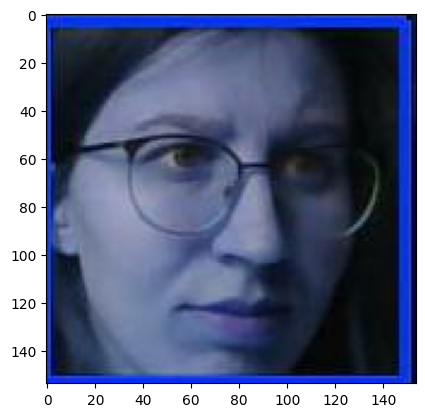

In [41]:
raw = cv.imread(f"face.jpg")
raw = cv.cvtColor(raw, cv.COLOR_BGR2RGB) # convert colorspace
plt.imshow(raw)
plt.show()

In [42]:
pil_transform = transforms.Compose([
    transforms.ToPILImage(), # Python Imaging Library
    # transforms.Resize(299),
    # transforms.CenterCrop(299),
    ])    

# adapt normalization from https://pytorch.org/vision/master/models.html
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     

preprocess_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize_transform
    ])


test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


PIL image is in mode:  RGB with  3 channels and size: (154, 154)


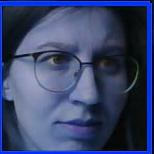

In [43]:
img = np.array(raw)
img = pil_transform(img)

print("PIL image is in mode: ", img.mode, "with ", len(img.split()), "channels and size:", img.size)
display(img)

In [44]:
img = test_transforms(img)
print(type(img))
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())
#plt.imshow(img[0].transpose(2,0).transpose(0,1))

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


## Predict the image

In [45]:
(img.shape)

torch.Size([1, 3, 224, 224])

In [46]:
model.eval()
out=model(img.cuda())
#print(out.shape)

## Find an Explanation for the Classification

For the Lime package install ````lime````

In [47]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [48]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    out = model(batch)
    probs = torch.nn.functional.softmax(out, dim=1)
    return probs.detach().numpy()

In [120]:
def get_score(img):
    model.eval()
    output = model(torch.tensor(img).cuda())
    return torch.sigmoid(output).item()

In [174]:
np.transpose(np_frame, (2, 0, 1)).shape

(3, 224, 224)

In [173]:
get_score(np.transpose(np_frame, (2, 0, 1)))


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [134]:
# squeeze: get rid of 4th dimension (1,3,224,224) -> (3,224,224) 
np_frame = np.array(pil_transform(img.squeeze(0)))
img.squeeze(0).reshape(224,224, -1)
img.shape

torch.Size([1, 3, 224, 224])

In [138]:
img.squeeze(0)#.reshape(224,224,3)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -1.9295, -1.9124, -1.8439],
         [-1.6555, -1.6898, -1.6898,  ..., -1.9638, -1.9124, -1.8439],
         [-1.3815, -1.4329, -1.4329,  ..., -1.9980, -1.9124, -1.8439],
         ...,
         [-2.0665, -1.9638, -1.8782,  ..., -1.9295, -2.1179, -2.1179],
         [-2.1179, -2.0837, -2.0323,  ..., -1.9295, -2.1179, -2.1179],
         [-2.1179, -2.1008, -2.0665,  ..., -1.9295, -2.1179, -2.1179]],

        [[-1.9482, -2.0007, -1.9657,  ..., -1.5980, -1.5980, -1.5455],
         [-1.2654, -1.3354, -1.3354,  ..., -1.6506, -1.5980, -1.5280],
         [-0.7402, -0.8102, -0.8452,  ..., -1.7031, -1.5980, -1.5280],
         ...,
         [-1.2479, -1.1429, -1.0903,  ..., -1.6506, -1.9307, -1.9482],
         [-1.2829, -1.2479, -1.2129,  ..., -1.6331, -1.9307, -1.9482],
         [-1.3004, -1.2654, -1.2304,  ..., -1.6331, -1.9132, -1.9307]],

        [[-0.0964, -0.2010, -0.2707,  ..., -1.2816, -1.3513, -1.3513],
         [ 0.8797,  0.7576,  0.6705,  ..., -1

In [140]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img.squeeze(0).reshape(224,224,3), 
                                         model, # classification function
                                         batch_size=1000
                                        #  top_labels=5, 
                                        #  num_samples=9) # number of images that will be sent to classification function
                                            )

AttributeError: 'Tensor' object has no attribute 'copy'

<class 'numpy.ndarray'>
(299, 299, 3)


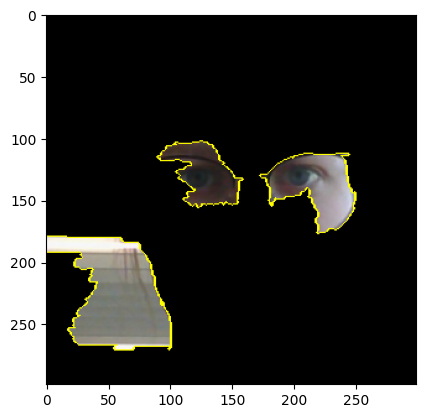

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
print(type(img_boundry1))
print(img_boundry1.shape)
plt.imshow(img_boundry1)

<div class="alert alert-block alert-success">
<b>Take Aways:</b> 

* We can analyze and visualize the decision process in a deep learning architecture (to some degree).
* The feature engineering transforms the image with focus on different aspects -- feature maps in the same layer learn different things.
* In the early layers, we can sometimes still interpret certain aspects of the image or the focus features.
* The results of later layers are non-readable for humans.
* For each instance that we want to explain, one new model is trained!
</div>

<div class="alert alert-block alert-warning">
<b>WARNING:</b> 

* When using pre-trained networks, always check the required preprocessing of the data!
</div>


# Test

In [188]:
import lime
from lime import lime_image
import numpy as np
from PIL import Image

# Step 1: Preprocess the image
image_path = 'face.jpg'
image = Image.open(image_path)
image = image.resize((224, 224))  # Resize to match the ResNet input size
image = np.array(image)

# Step 2: Load the ResNet model
# Load and initialize your ResNet model here

preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])


# Step 3: Define the classifier function
def classifier_fn(images):
    # Preprocess the images and feed them through the ResNet model
    preprocessed_images = preprocess(images)  # Implement the preprocessing function
    predictions = model(preprocessed_images)
    
    return predictions

# Step 4: Instantiate the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Step 5: Generate LIME explanations
explanation = explainer.explain_instance(img, classifier_fn, top_labels=5, num_samples=1000)

# Step 6: Visualize the explanation
explanation_image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_color = 0)
explanation_image = mark_boundaries(explanation_image, mask)

# Display or save the explanation image


ValueError: only 2D color images are supported

In [154]:
classifier_fn(image)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [186]:
# test 2

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(i for i in images), dim=0)
    
    out = model(batch)
    probs = torch.nn.functional.softmax(out, dim=1)
    return probs.detach().numpy()

def get_score(img):
    model.eval()
    output = model(torch.tensor(img).cuda())
    return torch.sigmoid(output).item()

print(type(img))
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img,
                                         get_score, # classification function
                                         top_labels=5, 
                                         num_samples=1000) # number of images that will be sent to classification function

<class 'torch.Tensor'>


ValueError: only 2D color images are supported